# Vector Data I/O in Python

Reading data into Python is usually the first step of an analysis workflow. There are various different GIS data formats available such as [Shapefile](https://en.wikipedia.org/wiki/Shapefile), [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON), [KML](https://en.wikipedia.org/wiki/Keyhole_Markup_Language), and [GPKG](https://en.wikipedia.org/wiki/GeoPackage). [Geopandas](http://geopandas.org/io.html) is capable of reading data from all of these formats (plus many more). 

This tutorial will show some typical examples how to read (and write) data from different sources. The main point in this section is to demonstrate the basic syntax for reading and writing data using short code snippets. You can find the example data sets in the data-folder. However, most of the example databases do not exists, but you can use and modify the example syntax according to your own setup.

## File formats

In geopandas, we use a generic function [from_file()](http://geopandas.org/reference.html#geopandas.GeoDataFrame.to_file) for reading in different data formats. In the bacground, Geopandas uses [fiona.open()](https://fiona.readthedocs.io/en/latest/fiona.html#fiona.open) when reading in data. Esri Shapefile is the default file format. For other file formats we need to specify which driver to use for reading in the data. 

You can check supported format drivers through geopandas, or directly from fiona: 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

# Check supported format drivers
import fiona

# Same as:
#import fiona
fiona.supported_drivers


# get the current directory
import os
cwd=os.getcwd()

### Read / write GeoDatabase

In [2]:
# Read file from File Geodatabase
fp = os.path.join(cwd,"../v108/globalislandsfix.gdb")
# list the areas
layers=fiona.listlayers(fp)
data = [ gpd.read_file(fp, driver="OpenFileGDB", layer=layer,  ignore_geometry=True,) for layer in layers]

# do all the layers have the same columns?
columns=[d.columns for d in data]
columns

[Index(['Name_USGSO', 'Plate', 'USGS_ISID', 'NEAR_FID', 'NEAR_DIST', 'ALL_Uniq',
        'Linework_S', 'Meaning_AL', 'ID_GID', 'NAME_wcmcI', 'NAME_LOCAL',
        'OBJECTID', 'ChangeType', 'ChangeNote', 'ChangeRef', 'Shape_Leng',
        'IslandArea', 'IslandCoas', 'Area_Geode', 'Coast_Geod', 'Shape_Length',
        'Shape_Area'],
       dtype='object'),
 Index(['OBJECTID', 'FID_EApoly', 'FID_Contin', 'Area_km2', 'Coastline_',
        'Shape_Leng', 'Shape_Le_1', 'Shape_Length', 'Shape_Area'],
       dtype='object'),
 Index(['Name_USGSO', 'Plate', 'USGS_ISID', 'NEAR_FID', 'NEAR_DIST', 'ALL_Uniq',
        'Linework_S', 'Meaning_AL', 'ID_GID', 'NAME_wcmcI', 'NAME_LOCAL',
        'OBJECTID', 'ChangeType', 'ChangeNote', 'ChangeRef', 'Shape_Leng',
        'IslandArea', 'IslandCoas', 'Area_Geode', 'Coast_Geod', 'Shape_Length',
        'Shape_Area'],
       dtype='object'),
 Index(['Name_USGSO', 'Plate', 'USGS_ISID', 'NEAR_FID', 'NEAR_DIST', 'ALL_Uniq',
        'Linework_S', 'Meaning_AL', 'ID_

In [3]:
# do all the layers have the same columns?
columns=[d.columns for d in data]
columns
layers

['USGSEsriWCMC_GlobalIslandsv2_BigIslands',
 'USGSEsriWCMC_GlobalIslandsv2_Continents',
 'USGSEsriWCMC_GlobalIslandsv2_SmallIslands',
 'USGSEsriWCMC_GlobalIslandsv2_VerySmallIslands']

In [4]:

#for each dataframe add a column with last part of layer name after _
for i in range(len(data)):
    data[i]['layer']=layers[i].split("_")[-1]

alldata=gpd.GeoDataFrame(pd.concat(data, ignore_index=True))
# drop records with "Continents" in the layer column
alldata=alldata[alldata.layer!="Continents"]
alldata=alldata[alldata.layer!="VerySmallIslands"]
ac=alldata.copy()
ac['layer']="All islands"
alldataplus=gpd.GeoDataFrame(pd.concat([alldata,ac], ignore_index=True))




In [13]:
# rename SmallIslands to "< 1 km2"
alldata.loc[alldata.layer=="SmallIslands","layer"]="< 1 km2"
# rename BigIslands to "> 1 km2"
alldata.loc[alldata.layer=="BigIslands","layer"]="> 1 km2"

# rename 'layer' to 'Area'
alldata.rename(columns={"layer":"Area"}, inplace=True)

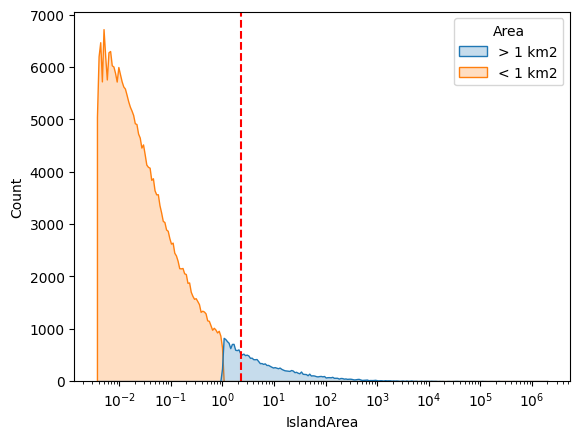

In [17]:
# Fit a distribution to IslandArea in all data and plot
import seaborn as sns
import matplotlib.pyplot as plt
ax=sns.histplot(alldata, x='IslandArea',  log_scale=True, hue='Area',  element="poly")
# Calculate and draw lines for the 75th, 90th, and 99th percentiles for each layer
percentiles = [95]
colors = ['red', 'green', 'blue']  # Different color for each percentile line

for i, percentile in enumerate(percentiles):
    # Calculate the percentile value across all data
    value = np.percentile(alldata['IslandArea'], percentile)
    plt.axvline(x=value, color=colors[i], linestyle='--', label=f'{percentile}th percentile')

# Add a legend to the plot at the bottom right
#plt.legend(title='Percentiles', loc='lower right')
#plt.legend(title='Percentiles')
plt.savefig("figure1a.svg", format="svg")
plt.show()


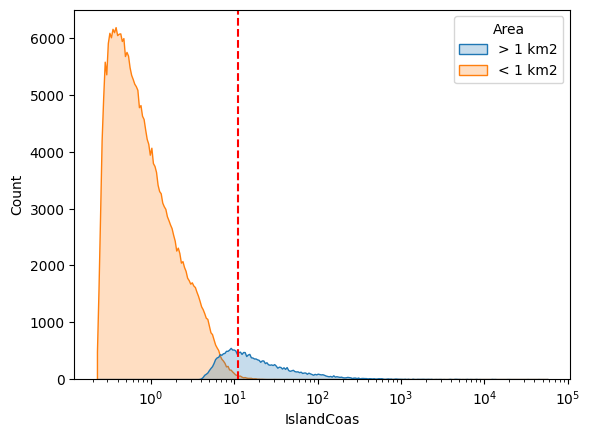

In [19]:
# Fit a distribution to IslandArea in all data and plot
import seaborn as sns
import matplotlib.pyplot as plt
ax=sns.histplot(alldata, x='IslandCoas',  log_scale=True, hue='Area',  element="poly")
# Calculate and draw lines for the 75th, 90th, and 99th percentiles for each layer
percentiles = [95]
colors = ['red', 'green', 'blue']  # Different color for each percentile line

for i, percentile in enumerate(percentiles):
    # Calculate the percentile value across all data
    value = np.percentile(alldata['IslandCoas'], percentile)
    plt.axvline(x=value, color=colors[i], linestyle='--', label=f'{percentile}th percentile')

# Add a legend to the plot at the bottom right
#plt.legend(title='Percentiles', loc='lower right')
#plt.legend(title='Percentiles')
plt.savefig("figure1b.svg", format="svg")
plt.show()

In [8]:
alldata.groupby('layer')['IslandArea'].agg(['min', 'max'])

,min,max
layer,,
BigIslands,0.993793,2.108459e+06
SmallIslands,0.003580,1.006380e+00
